# Deep Learning Exam
## Student: Raffaele Disabato
### Student ID: 0001057619

_Utility function and import_

In [ ]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np
from tensorflow.keras import datasets, layers, models

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [ ]:
%matplotlib inline
import time
import datetime
import pylab as pl

import IPython
from IPython import display

import matplotlib.animation as animation
import matplotlib.pyplot as plt

import absl.logging
from skimage.metrics import structural_similarity as ssim

absl.logging.set_verbosity(absl.logging.ERROR)

In [ ]:
def display_history(history):
    mse_training = history.history['loss']

    mse_val = history.history['val_loss']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training/validation')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [ ]:
def mse(imageA, imageB):
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  err /= float(imageA.shape[0] * imageA.shape[1])
  return err

def show_model_results(real_image, blurred_image, model):
  output_image = model.predict(np.reshape(blurred_image, (1, 32, 32, 3)))
  output_image = np.reshape(output_image, (32, 32, 3))
  
  fig, axs = plt.subplots(1, 3, figsize=(32, 32))
  for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
  
  axs[0].set_title("Original Image")
  axs[1].set_title("Blurred Image")
  axs[2].set_title("Deblurred Image")

  axs[0].imshow(real_image)
  axs[1].imshow(blurred_image)
  axs[2].imshow(output_image)

  print("MSE Clear Image / Deblurred: " + str(mse(real_image, output_image)))
  print("MSE Clear Image / Blurred: " + str(mse(real_image, blurred_image)))

In [ ]:
(blurred_train, clear_train), (blurred_test, clear_test) = getDataset()

170508288/170498071 [==============================] - 4s 0us/step


# First Model

Searching around I found an interesting paper$^{1}$ on a Gaussian noise removal from both grayscale and color images, so I tried to implement a network following the paper proposed network.




The architecture is basically devided in 3 parts

1. **Classifier**, a CNN classifier, not for classifing, but for extracting discriminative images features, that are used the the second part
2. **Denoiser**, it explicity removes the noise from image features learned in the first part
3. **Decoder**, it is needed to map back the denoised image features into the image pixels

In [ ]:
class FirstModel(tf.keras.Model):
  def __init__(self):
    super(FirstModel, self).__init__()
    # Classifier
    self.conv1 = tf.keras.layers.Conv2D(96, (3, 3), padding='same', activation='relu')
    
    self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
    self.conv3 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')

    self.bn1   = tf.keras.layers.BatchNormalization()

    self.conv4 = tf.keras.layers.Conv2D(190, (3, 3), padding='same', activation='relu')
    self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))

    # Denoiser
    self.conv5 = tf.keras.layers.Conv2D(190, (3, 3), padding='same', activation='relu')

    self.conv6 = tf.keras.layers.Conv2D(190, (3, 3), padding='same', activation='sigmoid')
    
    # Decoder
    self.conv7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')

    self.conv8 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
    self.conv9 = tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu')

    self.conv10 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
    self.conv11 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')

    self.upsample1 = tf.keras.layers.UpSampling2D((2, 2))

    self.conv12 = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')

  def call(self, inputs):
    output1 = self.conv1(inputs)

    output2 = self.conv2(output1)
    output3 = self.conv3(output2)

    output4 = tf.keras.layers.concatenate([output2, output3])
    output4 = self.bn1(output4)
    output4 = self.conv4(output4)
    output4 = self.maxpool1(output4)
    output4 = self.conv5(output4)
    output4 = self.conv6(output4)
    output4 = self.conv7(output4)

    output5 = self.conv8(output4)
    output6 = self.conv9(output4)

    output7 = tf.keras.layers.concatenate([output5, output6])
    output7 = self.conv10(output7)
    output7 = self.conv11(output7)
    output7 = self.upsample1(output7)
    output7 = self.conv12(output7)

    return output7

first_model = FirstModel()
first_model.build(input_shape=(None, 32, 32, 3))
first_model.summary()

Model: "first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         multiple                  2688      
                                                                 
 conv2d_107 (Conv2D)         multiple                  55360     
                                                                 
 conv2d_108 (Conv2D)         multiple                  102464    
                                                                 
 batch_normalization_4 (Batc  multiple                 512       
 hNormalization)                                                 
                                                                 
 conv2d_109 (Conv2D)         multiple                  219070    
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                     

I used the Adam optimizers with learning rate 0.0001, and the MSE as loss because we want to minimize that.

The validation split is set to 0.33, so the 33% of the train dataset is the validation datset, the epochs are 10, with an earlystopping in order to avoid overfitting.

In [ ]:
first_model_callback = tf.keras.callbacks.EarlyStopping(patience=1)

first_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss=tf.keras.losses.MSE)

first_history = first_model.fit(blurred_train, 
                                clear_train, 
                                validation_split=0.33, 
                                epochs=10, 
                                callbacks=[first_model_callback])

Epoch 1/10
1047/1047 [==============================] - 33s 30ms/step - loss: 0.0100 - val_loss: 0.0046
Epoch 2/10
1047/1047 [==============================] - 29s 28ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 3/10
1047/1047 [==============================] - 29s 28ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 4/10
1047/1047 [==============================] - 29s 28ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 5/10
1047/1047 [==============================] - 29s 28ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/10
1047/1047 [==============================] - 30s 29ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/10
1047/1047 [==============================] - 29s 28ms/step - loss: 0.0030 - val_loss: 0.0031


In [ ]:
eval_output = first_model.evaluate(blurred_test, clear_test, return_dict=True)

313/313 [==============================] - 3s 9ms/step - loss: 0.0031


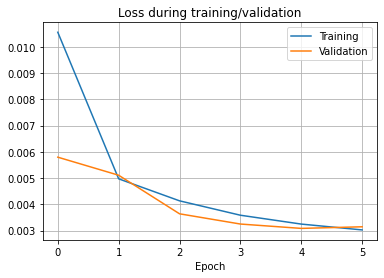

In [ ]:
display_history(first_history)

How we can se the model has some little underfitting/overfitting in the first epochs, but in the end, at the last epoch we only a little overfitting.

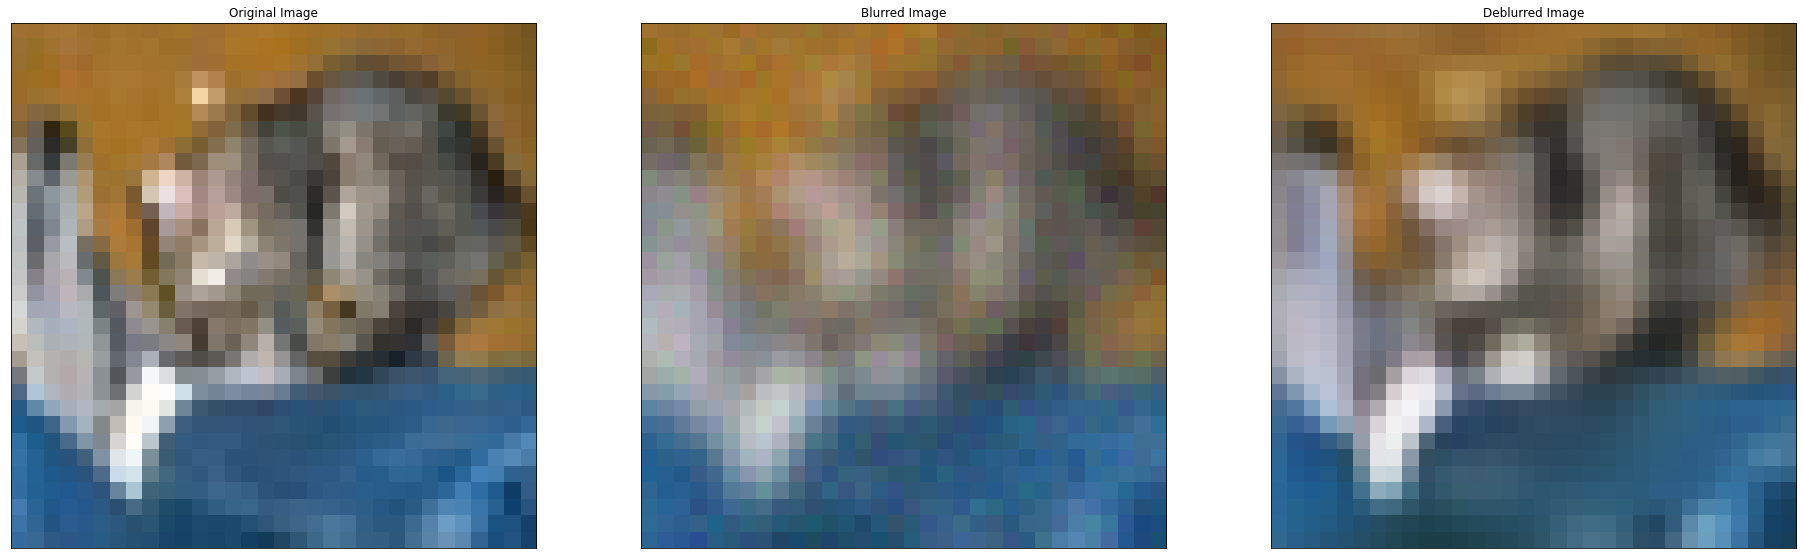

In [ ]:
show_model_results(clear_test[0], blurred_test[0], first_model)

# **Second Model**

For the second model I decided to create an U-Net based model, that is a convolutional neural network developed for
biomedical image segmentation. The main idea is to
supplement a usual contracting network by successive
layers, where pooling operations are replaced.

I defined 2 custom block of layers
1. **Residual Convolution Block (RCB)**, which is compose of two 2d Convolution with residual connection
2. **Residual Convolution with Bottleneck (RCBB)**, is like with RCB but with a bottleneck in the residual connection

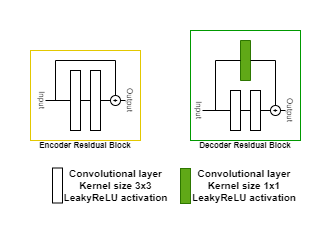

## **Architecture Description**

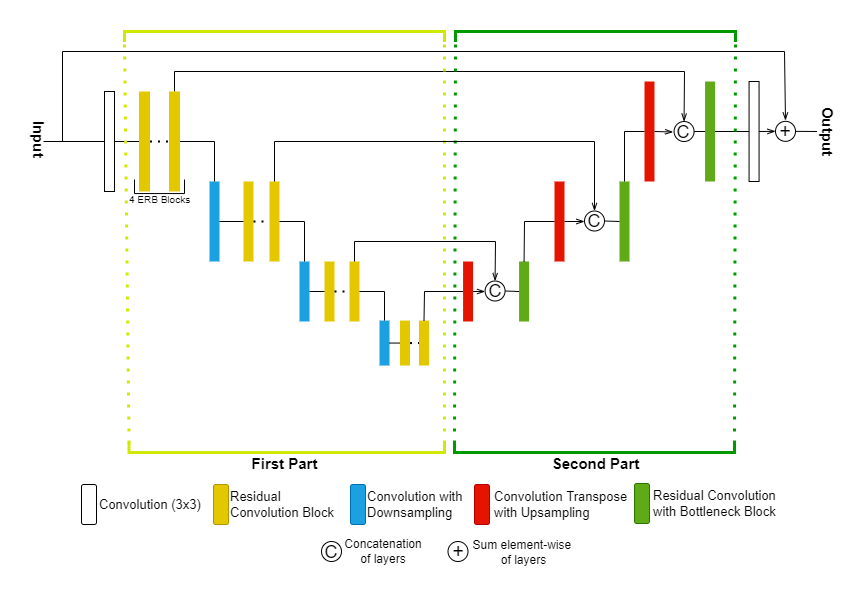

For semplicity in the description of the network, I divided the net in 2 part, the first part that has the convolutions with downsampling, and the second part that has the convolutions with upsampling.

At the start it has a convolution layer in order to get a depth as the input of the first 4 blocks of RCBs, in our case the depth is enlarged from 3 to 32.

In the first part it repeats the same layers, 3 times, these layers are:
1. a layer of convolution with the strides parameter set to (2, 2), for downsample
2. 4 blocks of RCBs, in order to try to learn some feature from downsampled images.
In every RCB the convolutions increase the depth of multiples of 2 up to 256.

In the second part it is the same, but with other layers: 
1. a convolution 2d transpose layer, with strides (2, 2), for upsampling, here it also decreases the depth of multiples of 2 to 32
2. the concatenation of the upsampling with the output of the corrisponding RCB in the first part of the net, in order to reuse the features extracted from downsampled images
3. 1 block of RCBB

Lastly it does a convolution in order to get the orgin depth of 3, and lastly it has an element-wise summation with the input layer in order to incorporate features of the input image in the output.



In [ ]:
class ResidualConvolutionBlock(tf.keras.layers.Layer):
    def __init__(self, channels):
      super(ResidualConvolutionBlock, self).__init__()
      self.conv1 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same', activation='relu')
      self.conv2 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same', activation='relu')

    def call(self, inputs):
      conv1 = self.conv1(inputs)
      conv2 = self.conv2(conv1)
      output = conv2 + inputs
      return output

class ResidualConvolutionBlockBottleneck(tf.keras.layers.Layer):
    def __init__(self, channels):
      super(ResidualConvolutionBlockBottleneck, self).__init__()
      self.conv1 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same')
      self.conv2 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same')
      self.bottleneck = tf.keras.layers.Conv2D(channels, (1, 1), padding='same')
      self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, inputs):
      conv1 = self.conv1(inputs)
      conv1 = tf.keras.layers.LeakyReLU()(conv1)

      conv2 = self.conv2(conv1)
      conv2 = tf.keras.layers.LeakyReLU()(conv2)

      output = conv2 + self.bottleneck(inputs)
      output = self.dropout(output)

      return output

class SecondModel(tf.keras.Model):
  def __init__(self):
    super(SecondModel, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
    self.rcbs1 = [ResidualConvolutionBlock(32), ResidualConvolutionBlock(32), ResidualConvolutionBlock(32), ResidualConvolutionBlock(32)]

    self.downsampling1 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')
    self.rcbs2 = [ResidualConvolutionBlock(64), ResidualConvolutionBlock(64), ResidualConvolutionBlock(64), ResidualConvolutionBlock(64)]

    self.downsampling2 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')
    self.rcbs3 = [ResidualConvolutionBlock(128), ResidualConvolutionBlock(128), ResidualConvolutionBlock(128), ResidualConvolutionBlock(128)]

    self.downsampling3 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')
    self.rcbs4 = [ResidualConvolutionBlock(256), ResidualConvolutionBlock(256), ResidualConvolutionBlock(256), ResidualConvolutionBlock(256)]

    self.upsampling1 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')
    self.leakyrelu1 = tf.keras.layers.LeakyReLU()
    self.rcbb1 = ResidualConvolutionBlockBottleneck(128)

    self.upsampling2 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')
    self.leakyrelu2 = tf.keras.layers.LeakyReLU()
    self.rcbb2 = ResidualConvolutionBlockBottleneck(64)

    self.upsampling3 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
    self.leakyrelu3 = tf.keras.layers.LeakyReLU()
    self.rcbb3 = ResidualConvolutionBlockBottleneck(32)

    self.last_conv = tf.keras.layers.Conv2D(3, (3, 3), padding='same')
  
  def call(self, inputs):
    output1 = self.conv1(inputs)

    for block in self.rcbs1:
      output1 = block(output1)

    output2 = self.downsampling1(output1)

    for block in self.rcbs2:
      output2 = block(output2)

    output3 = self.downsampling2(output2)

    for block in self.rcbs3:
      output3 = block(output3)

    output4 = self.downsampling3(output3)

    for block in self.rcbs4:
      output4 = block(output4)

    output5 = self.upsampling1(output4)
    output5 = self.upconv1(output5)
    output5 = self.leakyrelu1(output5)

    output5 = tf.keras.layers.concatenate([output3, output5])
    output5 = self.rcbb1(output5)

    output5 = self.upsampling2(output5)
    output5 = self.upconv2(output5)
    output5 = self.leakyrelu2(output5)

    output5 = tf.keras.layers.concatenate([output2, output5])
    output5 = self.rcbb2(output5)
    
    output5 = self.upsampling3(output5)
    output5 = self.upconv3(output5)
    output5 = self.leakyrelu3(output5)

    output5 = tf.keras.layers.concatenate([output1, output5])
    output5 = self.rcbb3(output5)

    output5 = self.last_conv(output5)
    output5 = tf.keras.layers.add([inputs, output5])
  
    return output5

second_model = SecondModel()
second_model.build(input_shape=(None, 32, 32, 3))
second_model.summary()

Model: "second_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 residual_convolution_block   multiple                 18496     
 (ResidualConvolutionBlock)                                      
                                                                 
 residual_convolution_block_  multiple                 18496     
 1 (ResidualConvolutionBlock                                     
 )                                                               
                                                                 
 residual_convolution_block_  multiple                 18496     
 2 (ResidualConvolutionBlock                                     
 )                                                               
                                                      

The optimizer and the loss are the same as in the first model, with some variation on the batch_size and epochs, the epochs value is tunend because after that the model goes in overfitting.

In [ ]:
second_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss="mse")

second_history = second_model.fit(blurred_train, clear_train, validation_split=0.33, epochs=200)

Epoch 1/200
1047/1047 [==============================] - 52s 36ms/step - loss: 0.0123 - val_loss: 0.0038
Epoch 2/200
1047/1047 [==============================] - 37s 35ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 3/200
1047/1047 [==============================] - 36s 35ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 4/200
1047/1047 [==============================] - 37s 35ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 5/200
1047/1047 [==============================] - 36s 35ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 6/200
1047/1047 [==============================] - 36s 35ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/200
1047/1047 [==============================] - 36s 35ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 8/200
1047/1047 [==============================] - 37s 35ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/200
1047/1047 [==============================] - 36s 35ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/200
1047/1047 [==============================]

In [ ]:
eval_output3 = second_model.evaluate(blurred_test, clear_test, return_dict=True)

313/313 [==============================] - 4s 12ms/step - loss: 0.0022


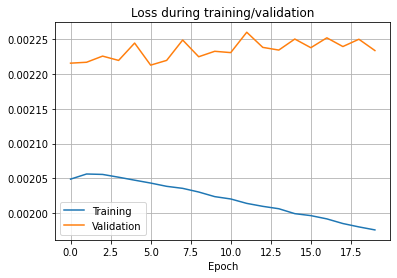

In [ ]:
display_history(second_history)

With this model I achived a lower value for the loss respect the first model and here we don't have overfitting at all, so I think I have improved the first model even if this has much more parameters than the first.

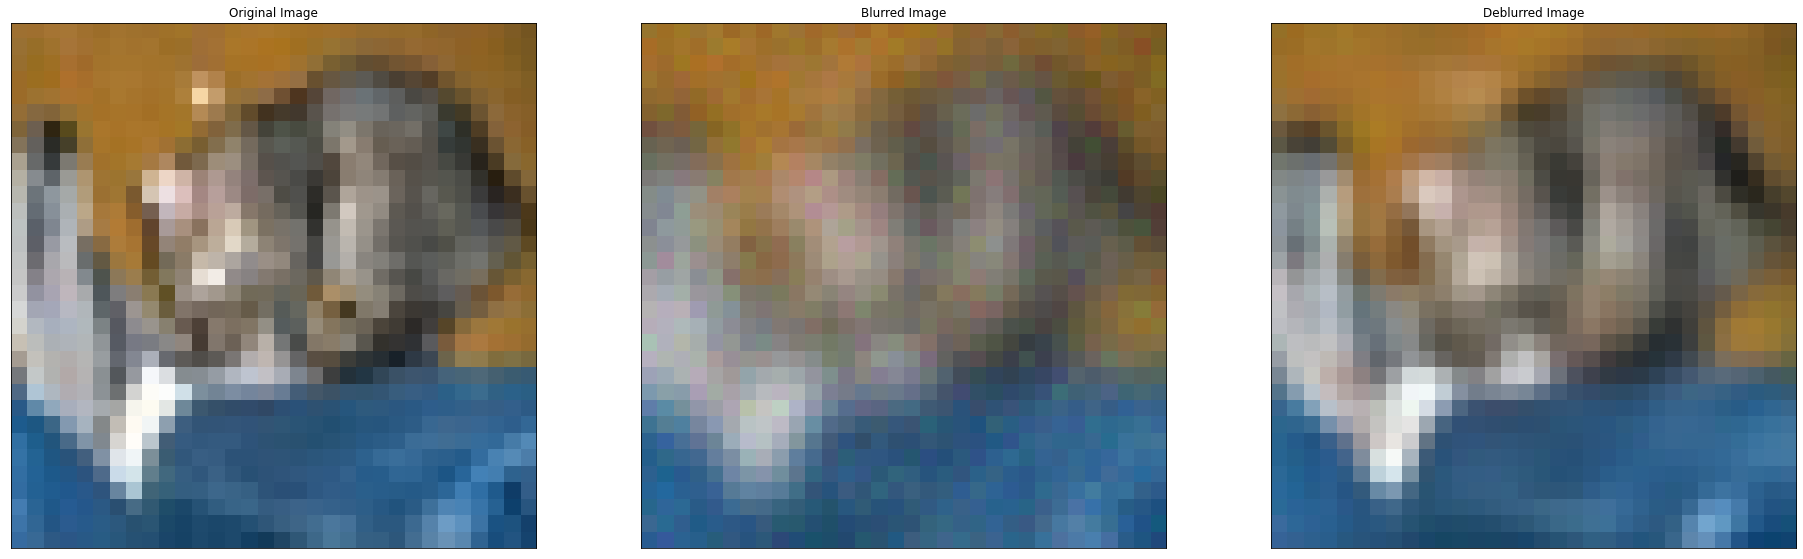

In [ ]:
show_model_results(clear_test[0], blurred_test[0], second_model)

# Third Model

In order to try to improve the second model, I decided to implement a cGAN (Conditional Generative Adversarial Network), with the second model as the generator and with a PatchGAN as discriminator.

A PathcGAN is a discriminator that tries to classify if each $N \times N$ patch in an image is real or fake.

In our task we need a conditional GAN and not a simple GAN, because we need to control the type of images that are produced from the generator, that is the deblurred/denoised image from the corrisponding blurred/noise image.

The main idea is that the generator learn and try to generate real clear image from the blurred/noise image, and the discriminator is trained to classify real clear image and fake clear image produced by the generator, this should improve the results obtained by the second model.





## **Discriminator**

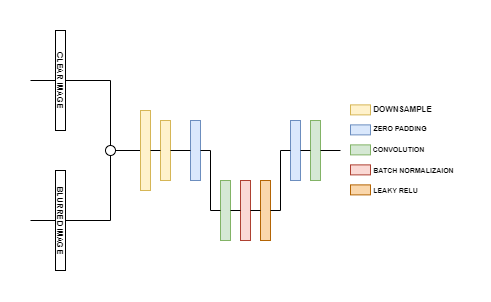

With ispiration to the pix2pix$^2$ architecture I used a similar discriminator, it has 2 input, the clear image and same image but with the noise/blur.

Every block in the discriminator is compose of
1. Convolution (with kernel size 3x3)
2. Batch Normalization
3. Leaky ReLU

The output has the shape (BATCH_SIZE, 6, 6, 1), so each $6 \times 6$ patch of the output classifies a $14 \times 14$ portion of the input image.

In the downsample block we have a convolution with strides in order to do a downsample.


In [ ]:
def downsample_block(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=(2, 2), padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
  
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=(32, 32, 3), name='input_image')
  tar = tf.keras.layers.Input(shape=(32, 32, 3), name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])

  down1 = downsample_block(64, 4, False)(x)
  down2 = downsample_block(128, 4)(down1)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)
  conv = tf.keras.layers.Conv2D(254, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 target_image (InputLayer)      [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 6)    0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']           
                                                                                                  
 sequential (Sequential)        (None, 16, 16, 64)   6144        ['concatenate[0][0]']        

Next we need to define the loss function for the generator and the discriminator, because a simple MSE is not useful for a cGAN and I decided to use the same loss as in the pix2pix architecture.

**GENERATOR LOSS**

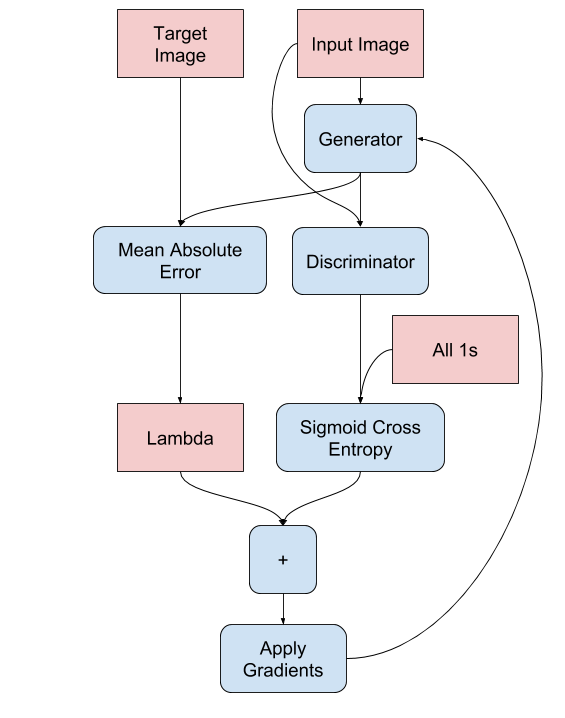

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  target = tf.cast(target, tf.float32)
  gen_output = tf.cast(gen_output, tf.float32)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

**DISCRIMINATOR LOSS**

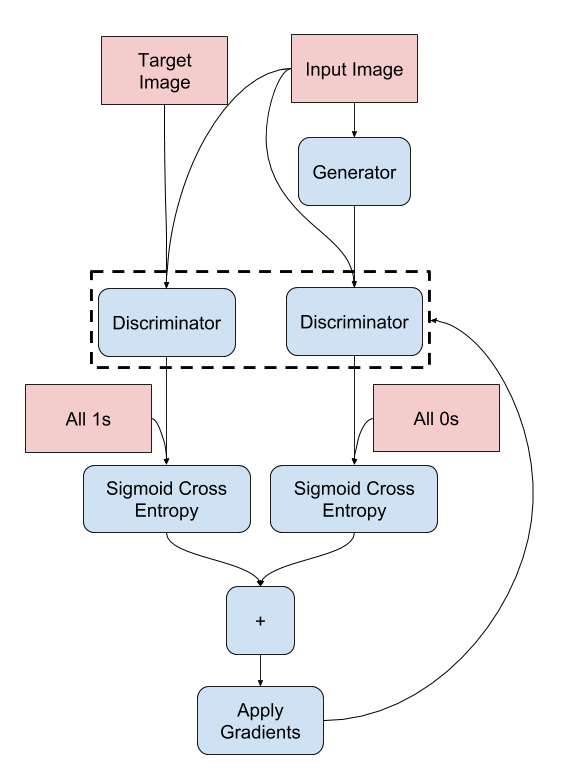

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

Next I need to define the fit and the train step and fit functions for the cGAN.

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # The generator deblur/denoise the input_image
    generated_images = generator(input_image, training=True)

    # We give the discriminator the clear image and the blurred image and save the classification
    # The discriminator should output that the image is real
    real_output = discriminator([input_image, target], training=True)

    # We do the same but with the claer image and the deblurred image of the generator
    # The discriminator should output that the image is a fake
    fake_output = discriminator([input_image, generated_images], training=True)

    # We calculate the loss for the generator and the discriminator
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, target)
    disc_loss = discriminator_loss(real_output, fake_output)
  
  # And then we apply the gradient with the calcualted loss through the optimizer
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  train_mse_metric.update_state(target, generated_images)


And the definition of the fit function for the cGAN

In [ ]:
gen_imgs = []

def generate_images(model, test_input, tar):
  prediction = model(np.reshape(test_input, (1, 32, 32, 3)), training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    im = plt.imshow(display_list[i])
    plt.axis('off')
  
  plt.show()
  gen_imgs.append([prediction[0]])

# Given a train dataset and a test dataset we do 'steps' number of train step
def fit(train_ds, test_ds, steps):
  mses_train = []
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    # Every 1000 step I print the MSE of the generator and the current result on the same image
    if (step) % 1000 == 0:
      # Update of the mse on training generator
      train_mse = train_mse_metric.result()
      train_mse_metric.reset_states()
      # Save the current mse in a list
      mses_train.append(float(train_mse))

      # Print the update mse, the time taken for the 1000 steps and update of the same image from the generator
      display.clear_output(wait=True)
      print("Training mse over epoch: %.4f" % (float(train_mse),))

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    # Main function that does the train step given a blurred image and his orginal image
    train_step(input_image, target, step)

    # Every 10 step write a point, for update visually the status on training
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save the checkpoint every 5000 steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
  return mses_train

In [ ]:
# Creation of the dataset on tensorflow so I can use function like take in the train step
# I took the batch size from the paper I saw this implementation, apparently is really good 1
BATCH_SIZE = 1
BUFFER_SIZE = 400

train_dataset = tf.data.Dataset.from_tensor_slices((blurred_train, clear_train))
# Don't need of this, so I can free the memory in colab
del blurred_train

test_dataset = tf.data.Dataset.from_tensor_slices((blurred_test, clear_test))
# Don't need of this, so I can free the memory in colab
del clear_train

# Shuffle and definition of the batch size
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
# My generator is the second model
generator = SecondModel()
discriminator = Discriminator()

# Definition of the mse metric so I can follow the generator mse during the training
train_mse_metric = tf.keras.metrics.MeanSquaredError()

# Definition of the optimizers for the discriminator and the generator
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Definition of the checkpoint for saving the weights
checkpoint_dir = './content/training_checkpoints'
checkpoint_prefix = checkpoint_dir + "/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Training mse over epoch: 0.0032
Time taken for 1000 steps: 16.40 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


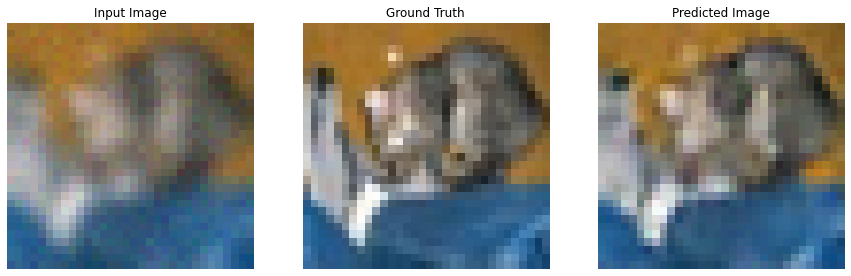

Step: 49k
....................................................................................................

In [ ]:
third_history = fit(train_dataset, test_dataset, 50000)
third_history = np.delete(third_history, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


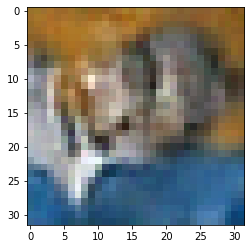

In [ ]:
fig = plt.figure()

def draw_generated_images(n):
  plt.imshow(gen_imgs[n][0])
  return

anim = animation.FuncAnimation(fig, draw_generated_images, frames = 10, interval = 500, blit = False)
IPython.display.display(anim)

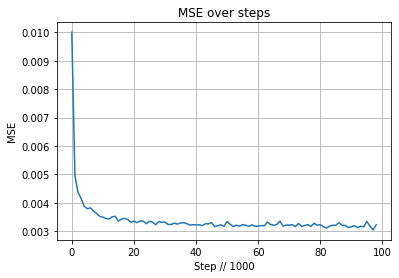

In [ ]:
plt.grid()
plt.ylabel("MSE")
plt.xlabel("Step // 1000")
plt.title("MSE over steps")
plt.plot(third_history);

In this case is really hard to check an overfitting for the gan, we can only see that the loss of the discriminator and the generator are converge towards 0.0032, but in particular we can see that the MSE is higher than the second model.

In [ ]:
index = np.random.choice(blurred_test.shape[0], 1, replace=False)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE Clear Image / Deblurred: 0.007910096063594697
MSE Clear Image / Blurred: 0.01250222443551281


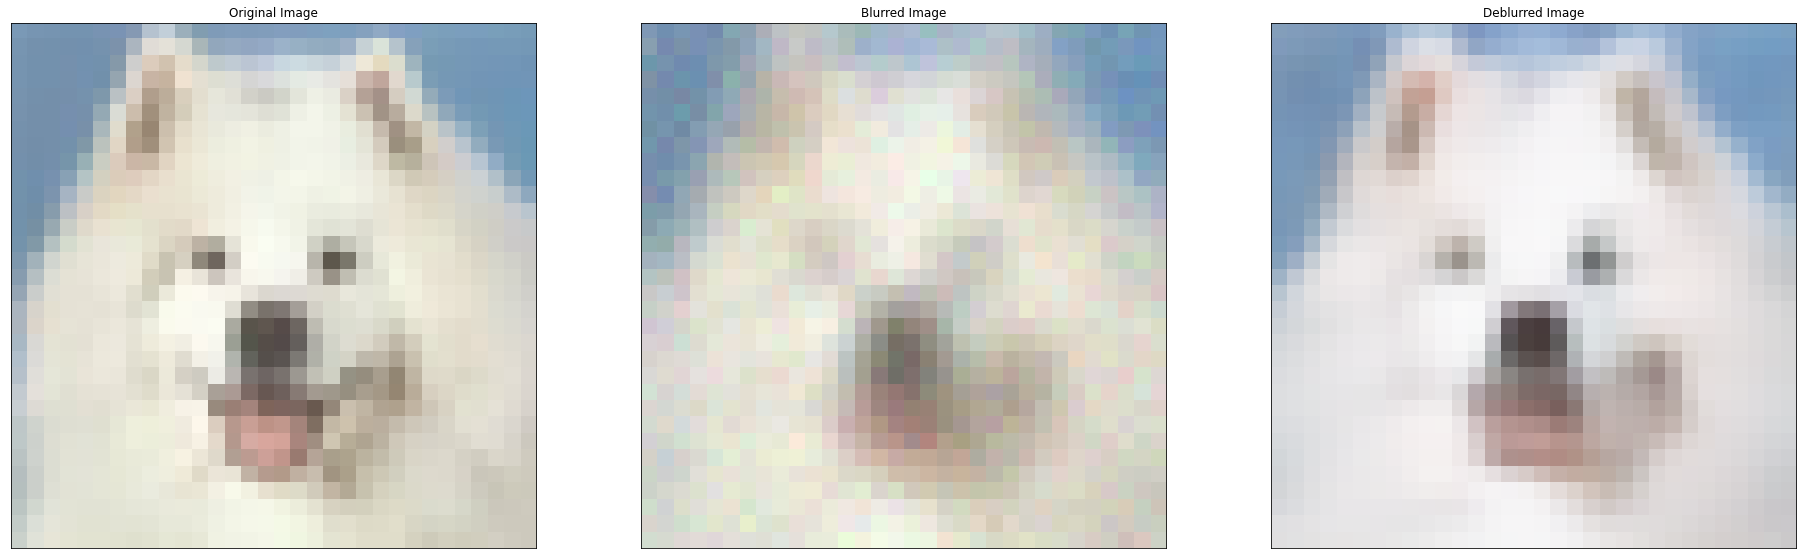

In [ ]:
show_model_results(clear_test[index], blurred_test[index], first_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE Clear Image / Deblurred: 0.003732526267203374
MSE Clear Image / Blurred: 0.01250222443551281


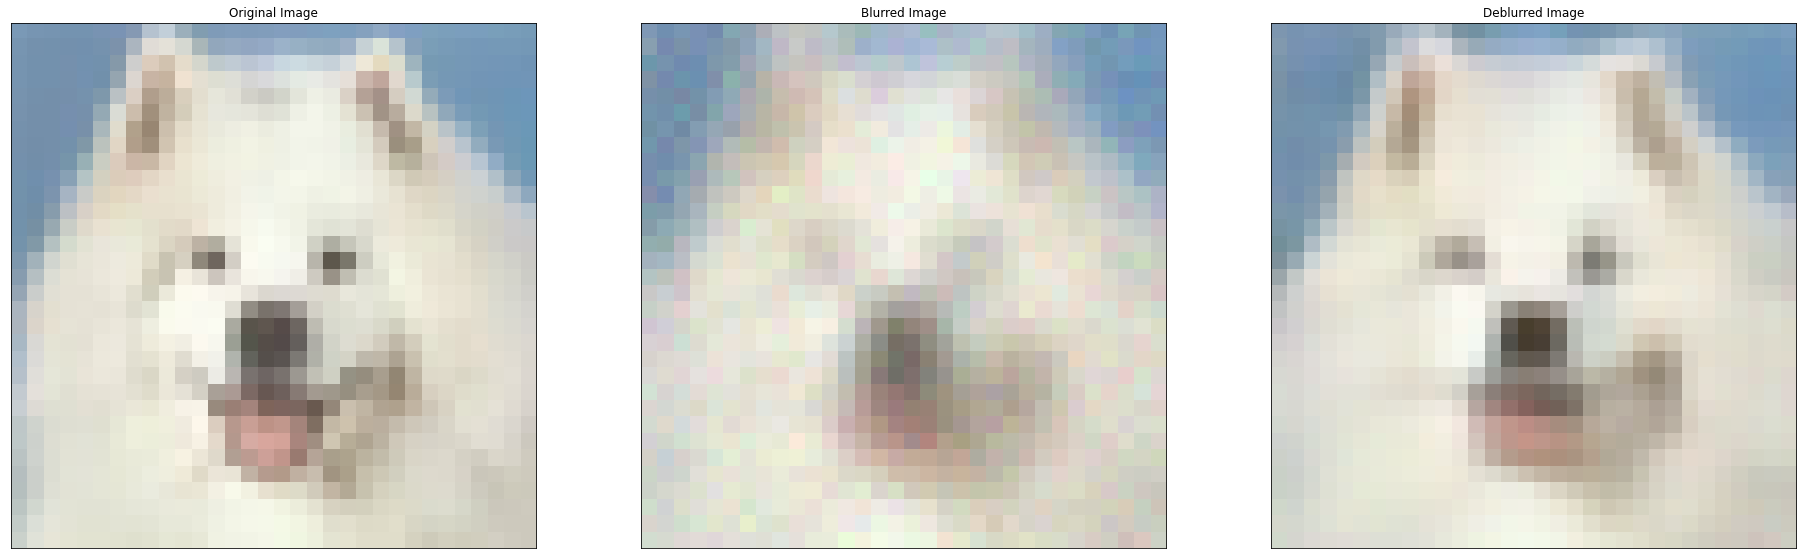

In [ ]:
show_model_results(clear_test[index], blurred_test[index], second_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE Clear Image / Deblurred: 0.004876831944781474
MSE Clear Image / Blurred: 0.01250222443551281


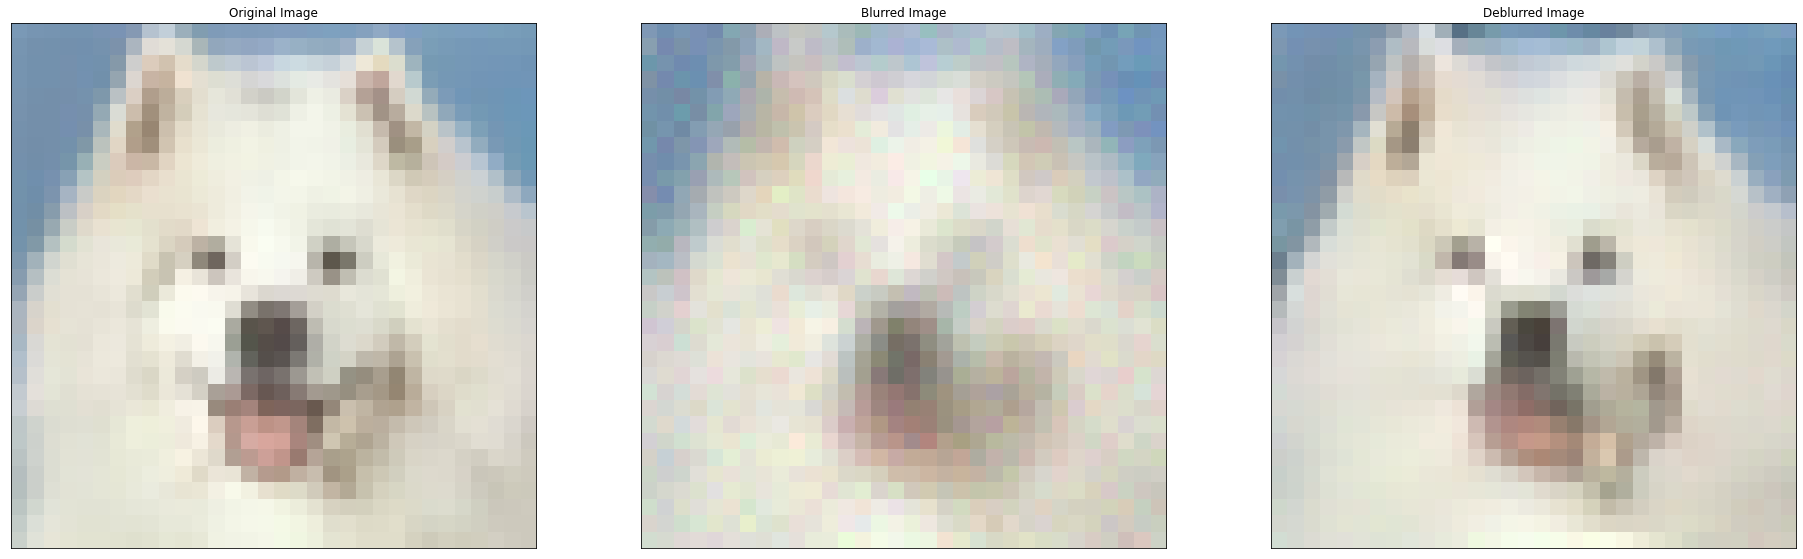

In [ ]:
show_model_results(clear_test[index], blurred_test[index], generator)

In [ ]:
second_model.evaluate()

# Conclusion

The best model for the MSE metric is the second even if the cGAN model generates images that have more details to the human eyes, indeed the SSIM, that is a perception-based model that considers image degradation as perceived change in structural information and the difference with techniques such as MSE or PSNR is that these approaches estimate absolute errors, is higher in the third model than the second.

So in end, we can say that for our task the second model is the best (it is my final model), because we have a MSE lower and much less parameters to train, in the third model we have the second model + the discriminator, much complex even in the control.


In [ ]:
def check_model_results_on_batch(blurred_images, clear_images, model):
  return model.evaluate(blurred_images, clear_images, return_dict=True)

# Where the loss is the MSE
check_model_results_on_batch(blurred_test, clear_test, second_model)

313/313 [==============================] - 4s 11ms/step - loss: 0.0022


{'loss': 0.002192483050748706}

$^1$Mickael Aghajarian and John E. McInroy and Suresh Muknahallipatna, "Deep learning algorithm for Gaussian noise removal from images", Journal of Electronic Imaging, 29 (4), 043005 (2020).
https://doi.org/10.1117/1.JEI.29.4.043005

$^2$Isola, Phillip and Zhu, Jun-Yan and Zhou, Tinghui and Efros, Alexei A, "Image-to-Image Translation with Conditional Adversarial Networks", arXiv (2016). https://doi.org/10.48550/arxiv.1611.07004